In [ ]:
#Imports
import pandas as pd
from numpy import savetxt
import numpy as np
import time
from datetime import datetime,timedelta
import math
import scipy
import scipy.integrate as integrate
import scipy.sparse as sparse
from scipy.linalg import lu_factor, lu_solve
!pip install arch
import arch
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

import tensorflow as tf
import tensorflow_probability as tfp
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from google.colab import drive
from google.colab import files

import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift

from sympy.solvers import solve
from sympy import Symbol
from scipy.stats import norm

import decimal
import itertools

     |████████████████████████████████| 808kB 7.1MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Processing

OEX: SECID 109764
XEO: SECID 112878

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
option_data = pd.read_csv('/content/drive/MyDrive/data aqf/oex option data 2000-2020.csv')
underlying_data=pd.read_csv('/content/drive/MyDrive/data aqf/oex underlying.csv')
vix_data=pd.read_csv('/content/drive/MyDrive/data aqf/vix index.csv')
interest_rate_data=pd.read_csv('/content/drive/MyDrive/data aqf/yield curve.csv')
option_data_european = pd.read_csv('/content/drive/MyDrive/data aqf/xeo option data 2002-2020.csv')
underlying_data[['numerical_date']] = underlying_data['date']
underlying_data[['date']] = pd.to_datetime(underlying_data['date'],format='%Y%m%d')
underlying_data['date'] = underlying_data["date"].dt.date
vix_data[['date']] = pd.to_datetime(vix_data['Date'],format='%Y%m%d')
vix_data['date'] = vix_data["date"].dt.date
interest_rate_data[['date']] = pd.to_datetime(interest_rate_data['date'],format='%Y%m%d')
interest_rate_data['date'] = interest_rate_data["date"].dt.date

# Data Cleaning

In [ ]:
def process_data(option_data,underlying_data,interest_rate_data,vix_data,is_American):
  option_data[['numerical_date']] = option_data['date']
  #Remove options with the wrong date
  min_date=20030101
  max_date=20121231
  option_data=option_data[(option_data['date'] >= min_date) & (option_data['date'] <= max_date)]
 
  #Remove options below a certain volume
  min_volume=1
  option_data=option_data[option_data['volume'] >= min_volume]
 
  #Remove call options
  option_data=option_data[ option_data['cp_flag'] == "P" ]
 
  #Create a time to maturity column (in trading days)
  option_data[['date']] = pd.to_datetime(option_data['date'],format='%Y%m%d')
  option_data['date'] = option_data["date"].dt.date
  option_data[['exdate']] = pd.to_datetime(option_data['exdate'],format='%Y%m%d')
  option_data['exdate'] = option_data["exdate"].dt.date
  if(is_American):
    option_data[['last_date']] = pd.to_datetime(option_data['last_date'],format='%Y%m%d')
    option_data['last_date'] = option_data["last_date"].dt.date
  option_data['maturity']=np.busday_count(option_data['date'],option_data['exdate'], weekmask='1111111') #Do we have to include weekends?
 
  #Remove options that do not have correct maturity
  min_maturity=7
  max_maturity=90
  option_data = option_data[(option_data['maturity'] <= max_maturity) & (option_data['maturity'] >= min_maturity)]
 
  #Create a column with market prices
  option_data['market price'] = (option_data['best_bid'] + option_data['best_offer'])/2
 
  #Add the underlying to the dataframe
  rows=option_data.shape[0]
  underlying_vec=np.empty(rows, dtype=object)
  date_selector=0
  row_number=0
  for index, row in option_data.iterrows():
    while (underlying_data.at[date_selector,'date']!=row['date']):
      date_selector=date_selector+1
    underlying_vec[row_number]=underlying_data.at[date_selector,'close']
    row_number=row_number+1
  option_data['underlying']=underlying_vec
 
  #Create columns moneyness and time value
  option_data['moneyness'] = option_data['underlying'] / option_data['strike_price'] * 1000
  option_data['time value'] =  option_data['market price'] - (option_data['strike_price']/1000 - option_data['underlying'])
 
  #Create column with forward volume
  option_data['1d forward volume'] = option_data.groupby(['optionid'])['volume'].shift(-1)
 
  #Cleaning based on Ruf and Wang 2020 (https://github.com/weiguanwang/Hedging_Neural_Networks/tree/74d5a7b72626e92395d056ced01cb8e135edcbcc)
  option_data.dropna(subset=['impl_volatility'], how='any', inplace=True)
  option_data = option_data[(option_data['impl_volatility'] < 1) & (option_data['impl_volatility'] > 0.01)] 
  option_data = option_data[option_data['volume'] > 0]
  option_data = option_data[option_data['best_bid'] > 0.05]
  option_data = option_data[(option_data['time value']> 0)]
  option_data = option_data[ (2*option_data['best_bid'] > option_data['best_offer'])]
  option_data = option_data[~option_data['1d forward volume'].isna()]
  if(is_American):
    option_data = option_data[option_data['last_date'] == option_data['date']]
 
  if (is_American):
    #Add the VIX to the dataframe
    rows=option_data.shape[0]
    vix_vec=np.empty(rows, dtype=object)
    date_selector=0
    row_number=0
    for index, row in option_data.iterrows():
      while (vix_data.at[date_selector,'date']!=row['date']):
        date_selector=date_selector+1
      vix_vec[row_number]=vix_data.at[date_selector,'vxo']
      if isinstance(vix_vec[row_number], (int, float, complex)):
        1+1
      else:
        print("no number " + str(vix_vec[row_number]))
      row_number=row_number+1
    option_data['vix']=vix_vec
 
  #Add the interest to the dataframe -> maybe should scale it somehow
  rows=option_data.shape[0]
  interest_rate_vec=np.empty(rows, dtype=object)
  date_selector=0
  row_number=0
  for index, row in option_data.iterrows():
    while (interest_rate_data.at[date_selector,'date']<row['date']): #There are dates where options are traded, but no interest is quoted
      date_selector=date_selector+1
      if date_selector>=216968:
        print(date_selector)
        print(interest_rate_data.at[date_selector,'date'])
        print(row['date'])
    i=0
    while (interest_rate_data.at[date_selector+i,'days']<row['maturity']):
      i=i+1
    left_gap=row['maturity']-interest_rate_data.at[date_selector+i-1,'days']
    right_gap=interest_rate_data.at[date_selector+i,'days']-row['maturity']
    if left_gap<right_gap:
      i=i-1
    interest_rate_vec[row_number]=interest_rate_data.at[date_selector+i,'rate']
    row_number=row_number+1
  option_data['interest_rate']=interest_rate_vec
 
  option_data['maturity']=option_data['maturity']/250
  option_data['strike_price']=option_data['strike_price']/1000
 
  return option_data

In [ ]:
option_data=process_data(option_data,underlying_data,interest_rate_data,vix_data,True)
option_data_european=process_data(option_data_european,underlying_data,interest_rate_data,vix_data,False)
option_data

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,optionid,forward_price,index_flag,issuer,exercise_style,numerical_date,maturity,market price,underlying,moneyness,time value,1d forward volume,vix,interest_rate
215739,109764,2003-01-02,2003-01-18,2003-01-02,P,500.0,41.30,42.80,2,0.323715,20842600,NaN,1,CBOE S&P 100 INDEX,A,20030102,0.064,42.050,459.5,0.919,1.55,4.0,28.52,1.37095
215800,109764,2003-01-02,2003-01-18,2003-01-02,P,370.0,0.10,0.15,330,0.456722,20873060,NaN,1,CBOE S&P 100 INDEX,A,20030102,0.064,0.125,459.5,1.24189,89.625,155.0,28.52,1.37095
215805,109764,2003-01-02,2003-02-22,2003-01-02,P,340.0,0.55,0.85,17,0.428497,20873063,NaN,1,CBOE S&P 100 INDEX,A,20030102,0.204,0.700,459.5,1.35147,120.2,49.0,28.52,1.39453
215807,109764,2003-01-02,2003-02-22,2003-01-02,P,360.0,1.05,1.45,300,0.399460,20873064,NaN,1,CBOE S&P 100 INDEX,A,20030102,0.204,1.250,459.5,1.27639,100.75,54.0,28.52,1.39453
215808,109764,2003-01-02,2003-02-22,2003-01-02,P,370.0,1.45,1.85,39,0.384597,21341739,NaN,1,CBOE S&P 100 INDEX,A,20030102,0.204,1.650,459.5,1.24189,91.15,15.0,28.52,1.39453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264305,109764,2012-12-28,2013-02-16,2012-12-28,P,620.0,11.50,12.30,7,0.198526,83448206,NaN,1,CBOE S&P 100 INDEX,A,20121228,0.200,11.900,636.17,1.02608,28.07,37.0,23.07,0.274633
1264306,109764,2012-12-28,2013-02-16,2012-12-28,P,640.0,18.90,19.80,2,0.176025,83448207,NaN,1,CBOE S&P 100 INDEX,A,20121228,0.200,19.350,636.17,0.994016,15.52,66.0,23.07,0.274633
1264307,109764,2012-12-28,2013-02-16,2012-12-28,P,660.0,29.30,31.50,7,0.148371,83448208,NaN,1,CBOE S&P 100 INDEX,A,20121228,0.200,30.400,636.17,0.963894,6.57,10.0,23.07,0.274633
1264338,109764,2012-12-28,2013-03-16,2012-12-28,P,640.0,23.50,24.40,3,0.175640,83151400,NaN,1,CBOE S&P 100 INDEX,A,20121228,0.312,23.950,636.17,0.994016,20.12,1.0,23.07,0.288166


# Tables data

Code that creates tables that describe summary statistics of the data

In [ ]:
moneyness_vec=np.array([0.94,0.97,1,1.03,1.06])
maturity_vec=np.array([30,60])/250
mean_matrix=np.zeros([len(moneyness_vec)+2,len(maturity_vec)+2])
sd_matrix=np.zeros([len(moneyness_vec)+2,len(maturity_vec)+2])
amount_matrix=np.zeros([len(moneyness_vec)+2,len(maturity_vec)+2])

for m in range(0,len(moneyness_vec)+2):
  for t in range(0,len(maturity_vec)+2):
    if (m==0):
      moneyness_lower_bound=0
      moneyness_upper_bound=moneyness_vec[m]
    if (m>0 and m<len(moneyness_vec)):
      moneyness_lower_bound=moneyness_vec[m-1]
      moneyness_upper_bound=moneyness_vec[m]
    if (m==len(moneyness_vec)):
      moneyness_lower_bound=moneyness_vec[m-1]
      moneyness_upper_bound=10**8
    if (m==len(moneyness_vec)+1):
      moneyness_lower_bound=0
      moneyness_upper_bound=10**8
    if (t==0):
      maturity_lower_bound=0
      maturity_upper_bound=maturity_vec[t]
    if (t>0 and t<len(maturity_vec)):
      maturity_lower_bound=maturity_vec[t-1]
      maturity_upper_bound=maturity_vec[t]
    if (t==len(maturity_vec)):
      maturity_lower_bound=maturity_vec[t-1]
      maturity_upper_bound=10**8
    if (t==len(maturity_vec)+1):
      maturity_lower_bound=0
      maturity_upper_bound=10**8
    options=option_data[(option_data['maturity'] >= maturity_lower_bound) & (option_data['maturity'] <= maturity_upper_bound) & (option_data['moneyness'] >= moneyness_lower_bound) & (option_data['moneyness'] <= moneyness_upper_bound)]
    mean_matrix[m,t]=np.mean(options['market price'])
    sd_matrix[m,t]=np.std(options['market price'])
    amount_matrix[m,t]=len(options['market price'])
mean_matrix=np.around(mean_matrix,2)
sd_matrix=np.around(sd_matrix,2)
amount_matrix=np.around(amount_matrix,0)

for m in range(0,len(moneyness_vec)+2):
  for t in range(0,len(maturity_vec)+2):
    if (t==0):
      print(" & Price & " + str(mean_matrix[m,t]) + " & " + str(sd_matrix[m,t]) + " & ", end =" ")
    elif (t==len(maturity_vec)+1):
      print(str(mean_matrix[m,t]) + " & " + str(sd_matrix[m,t]), end =" ")
    else: 
      print(str(mean_matrix[m,t]) + " & " + str(sd_matrix[m,t]) + " & ", end =" ")
  print("\\" + "\\")
  for t in range(0,len(maturity_vec)+2):
    if (t==0):
      print(" & Observations & " + str(int(amount_matrix[m,t])) + " & & ", end =" ")
    elif (t==len(maturity_vec)+1):
      print(str(int(amount_matrix[m,t])) + " & ", end =" ")
    else:
      print(str(int(amount_matrix[m,t])) + " & & ", end =" ")
  print("\\" + "\\")

print()

year_vec=np.array([2003,2004,2005,2006,2007,2008,2009,2010,2011,2012])
moneyness_vec=np.array([0.97,1.03])
maturity_vec=np.array([30,60])/250
amount_matrix_moneyness=np.zeros([len(year_vec),len(moneyness_vec)+1])
amount_matrix_maturity=np.zeros([len(year_vec),len(maturity_vec)+2])
for m in range(0,len(moneyness_vec)+1):
  for y in range(0,len(year_vec)):
    if (m==0):
      moneyness_lower_bound=0
      moneyness_upper_bound=moneyness_vec[m]
    if (m>0 and m<len(moneyness_vec)):
      moneyness_lower_bound=moneyness_vec[m-1]
      moneyness_upper_bound=moneyness_vec[m]
    if (m==len(moneyness_vec)):
      moneyness_lower_bound=moneyness_vec[m-1]
      moneyness_upper_bound=10**8
    options=option_data[(option_data['numerical_date'] >= year_vec[y]*10**4) & (option_data['numerical_date'] < (year_vec[y]+1)*10**4) & (option_data['moneyness'] >= moneyness_lower_bound) & (option_data['moneyness'] < moneyness_upper_bound)]
    amount_matrix_moneyness[y,m]=len(options['market price'])
for t in range(0,len(maturity_vec)+2):
  for y in range(0,len(year_vec)):
    if (t==0):
      maturity_lower_bound=0
      maturity_upper_bound=maturity_vec[t]
    if (t>0 and t<len(maturity_vec)):
      maturity_lower_bound=maturity_vec[t-1]-(1/250)+(1/1000)
      maturity_upper_bound=maturity_vec[t]+(1/250)-(1/1000)
    if (t==len(maturity_vec)):
      maturity_lower_bound=maturity_vec[t-1]
      maturity_upper_bound=10**8
    if (t==len(maturity_vec)+1):
      maturity_lower_bound=0
      maturity_upper_bound=10**8
    options=option_data[(option_data['numerical_date'] >= year_vec[y]*10**4) & (option_data['numerical_date'] < (year_vec[y]+1)*10**4) & (option_data['maturity'] > maturity_lower_bound) & (option_data['maturity'] < maturity_upper_bound)]
    amount_matrix_maturity[y,t]=len(options['market price'])

for y in range(0,len(year_vec)):
  for m in range(0,len(moneyness_vec)+1+len(maturity_vec)+1+1):
    if (m<len(moneyness_vec)+1):
      if (m==0):
        print(str(year_vec[y]) + " & " + str(int(amount_matrix_moneyness[y,m])), end =" ")
      else:
        print(" & " + str(int(amount_matrix_moneyness[y,m])), end =" ")
    else:
      print(" & " + str(int(amount_matrix_maturity[y,m-(len(moneyness_vec)+1)])), end =" ")
  print("\\" + "\\")

 & Price & 58.52 & 27.26 &  67.75 & 40.51 &  75.86 & 42.0 &  65.4 & 36.43 \\
 & Observations & 1900 & &  2064 & &  920 & &  4677 &  \\
 & Price & 27.36 & 5.57 &  30.24 & 6.03 &  34.31 & 7.01 &  29.55 & 6.43 \\
 & Observations & 2892 & &  2804 & &  916 & &  6351 &  \\
 & Price & 13.62 & 4.88 &  17.67 & 5.71 &  21.44 & 6.71 &  16.65 & 6.25 \\
 & Observations & 6061 & &  6772 & &  2477 & &  14737 &  \\
 & Price & 5.72 & 3.83 &  10.47 & 5.17 &  14.43 & 6.24 &  9.51 & 5.93 \\
 & Observations & 6395 & &  8042 & &  3428 & &  17186 &  \\
 & Price & 2.79 & 2.9 &  6.31 & 4.41 &  9.75 & 5.49 &  5.65 & 4.87 \\
 & Observations & 5747 & &  7228 & &  2855 & &  15234 &  \\
 & Price & 1.42 & 1.92 &  2.91 & 3.0 &  4.49 & 3.99 &  2.82 & 3.19 \\
 & Observations & 13507 & &  23782 & &  10012 & &  45350 &  \\
 & Price & 9.44 & 15.41 &  10.72 & 16.61 &  13.42 & 18.62 &  10.78 & 16.59 \\
 & Observations & 36487 & &  50674 & &  20600 & &  103496 &  \\

2003 & 1232  & 2873  & 6258  & 3160  & 4949  & 2254  & 103

#Implied vol plot

Some experimental plots with prices and implied volatility, didnt make the paper

0
1
2
3
4
5
6
7
8
9
10
11
12
13
MAPE: 0.5427445003077614
RMSE: 4.699854867265267
total time: 0.7155412279980737, time per option: 0.05111008771414812
0
1
2
3
4
5
6
7
8
9
10
11
12
13
MAPE: 0.461109173410865
RMSE: 4.478219261225725
total time: 0.8187739219983996, time per option: 0.058483851571314256


Text(0.5, 0, 'Moneyness')

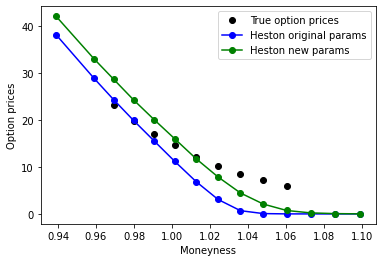

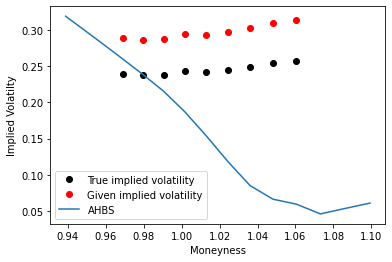

In [ ]:
#Obtain data for plotting
#In this case I use options with a 30 day maturity, that are traded in the first month of 2003
plot_data=option_data[(option_data['numerical_date']>20030000) & (option_data['numerical_date']<20030200) & (option_data['maturity']<31/250) & (option_data['maturity']>29/250) & (option_data['moneyness']>0) & (option_data['moneyness']<1.1)]
maturity=plot_data['maturity'].to_numpy()
interest_rate=plot_data['interest_rate'].to_numpy()/250
strike=plot_data['strike_price'].to_numpy()
underlying=plot_data['underlying'].to_numpy()
implied_vol_given=plot_data['impl_volatility'].to_numpy()
moneyness=plot_data['moneyness'].to_numpy()
price=plot_data['market price'].to_numpy()

#Only plot options that are not too deep
ind=np.where((moneyness>0.96) & (moneyness<1.07))
plt.figure(0)
plt.plot(moneyness[ind],price[ind],".k", markersize=12)


#THIS EXTENDS THE PLOT TO LOWER MONEYNESS
#moneyness=np.hstack((moneyness,np.linspace(0.8,0.96,len(moneyness))))
#strike=np.hstack((strike,strike))
#underlying=np.multiply(moneyness,strike)
#plot_data=pd.concat((plot_data,plot_data))
#plot_data['underlying']=underlying
#plot_data['strike_price']=strike
##

#Price with Heston model
Heston = HestonModel(option_data_european,underlying_data)
#model = AdHocBlackScholes(train)
params=np.array([ 1.20106692e+00,  8.86737492e-02,  3.21321381e-01,  1.12821414e-03, -2.39050628e-01])
params2 = np.array([0.489844, 0.140483, 4.734988, 0.069948, -0.147300])
heston_prices=Heston.price_american_options(plot_data,params)
heston_prices2=Heston.price_american_options(plot_data,params2)
#AHBS_prices=model.price_AH_BS(plot_data)
plt.plot(moneyness,heston_prices,marker='o',color='b')
plt.plot(moneyness,heston_prices2,marker='o',color='g')
plt.legend(['True option prices','Heston original params', 'Heston new params'])
plt.ylabel('Option prices')
plt.xlabel('Moneyness')

##IMPLIED VOL CALCULATION
N = norm.cdf

def bs_put(S, K, T, r, vol):
    '''
    Calculates Black-Scholes put price
    '''
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return -S * norm.cdf(-d1) + np.exp(-r * T) * K * norm.cdf(-d2)

def bs_vega(S, K, T, r, sigma):
    '''
    Calculates Black-Scholes vega
    '''
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, *args):
    '''
    Newton method for finding implied volatilty
    '''
    MAX_ITERATIONS = 2000
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_put(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

def implied_vol(underlying,strike,interest_rate,maturity,prices):
    '''
    Calculates implied volatility for given data
    '''
    implied_vol_vec=np.zeros(len(prices))
    for i in range(0,len(prices)):
      implied_vol_vec[i]=find_vol(prices[i],underlying[i],strike[i],maturity[i],interest_rate[i])
    return implied_vol_vec

def calculate_prices(underlying,strike,interest_rate,maturity,vol):
    '''
    Calculates Black-Scholes prices for given data
    '''
    prices_vec=np.zeros(len(vol))
    for i in range(0,len(vol)):
      prices_vec[i]=bs_put(underlying[i],strike[i],maturity[i],interest_rate[i],vol[i])
    return prices_vec
####

#Calculate and plot implied volatilities
implied_vol_market=implied_vol(underlying,strike,interest_rate,maturity,price) #*250/365
implied_vol_heston=implied_vol(underlying,strike,interest_rate,maturity,heston_prices)
#prices_vol = calculate_prices(underlying,strike,interest_rate,maturity,implied_vol_market)
#plt.plot(moneyness[ind],prices_vol[ind],".r", markersize=12)

plt.figure(1)
plt.plot(moneyness[ind],implied_vol_market[ind],".k", markersize=12)
plt.plot(moneyness[ind],implied_vol_given[ind],".r", markersize=12)
plt.plot(moneyness,implied_vol_heston)
plt.legend(['True implied volatility', 'Given implied volatility', 'AHBS'])
plt.ylabel('Implied Volatilty')
plt.xlabel('Moneyness')


#Plots and tables results

Creates the tables and figures for the results section


In [ ]:
##HELPER functoions
def rmse(y_true,y_pred):
  '''
  Calculates RMSE
  '''
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

def mape(y_true,y_pred):
  '''
  Calculates MAPE
  '''
  return np.mean(np.divide(abs(y_true-y_pred),y_true))

def print_table(labels,mape_mat,rmse_mat):
  '''
  Prints data in Latex table format
  '''
  rmse_mat=np.around(rmse_mat,4)
  mape_mat=np.around(mape_mat,4)
  for m in range(0,len(labels)):
      print(labels[m] + " & ", end = "")
      for j in range(0,2):
        for i in range(0,4):
          if j==0:
            if abs(decimal.Decimal(str(mape_mat[m,i])).as_tuple().exponent) < 4:
              print(str(mape_mat[m,i]) + "0 & ", end = "")
            else:
              print(str(mape_mat[m,i]) + " & ", end = "")
          else:
            if i==3:
              if abs(decimal.Decimal(str(rmse_mat[m,i])).as_tuple().exponent) < 4:
                print(str(rmse_mat[m,i]) + "0", end = "")
              else:
                print(str(rmse_mat[m,i]), end =" ")
              print("\\" + "\\")
            else:
              if abs(decimal.Decimal(str(rmse_mat[m,i])).as_tuple().exponent) < 4:
                print(str(rmse_mat[m,i]) + "0 & ", end = "")
              else:
                print(str(rmse_mat[m,i]) + " & ", end = "")

In [ ]:
##DATA
market_prices=option_data['market price']

#Add the model estimated prices here
ahbs_estimation = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/ahbs_estimation.csv',header=None)
ahbs_prediction = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/ahbs_prediction.csv',header=None)
heston_prediction = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/heston_prediction.csv',header=None)
heston_estimation=heston_prediction
ann_estimation = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/ANN_estimation.csv',header=None)
ann_prediction = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/ANN_prediction.csv',header=None,skip_blank_lines=False) ##Missing some zeros
ann_prediction.columns=['temp']
zeros = pd.DataFrame({'temp': np.zeros(31071)})
ann_prediction=zeros.append(ann_prediction,ignore_index=True)
bnn_estimation = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/BNN_estimation.csv',header=None)
bnn_prediction = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/BNN_prediction.csv',header=None)
gann_prediction = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/gann_prediction.csv',header=None)
gann_estimation = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/gann_estimation.csv',header=None)
gbnn_prediction = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/gbnn_prediction_BETTER3.csv',header=None)
gbnn_estimation = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/gbnn_estimation_BETTER3.csv',header=None)
svr_estimation = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/svr_estimation.csv',header=None)
svr_prediction = pd.read_csv('/content/drive/MyDrive/data aqf/estimation and prediction/svr_prediction.csv',header=None)

##INPUTS
estimated_prices=np.hstack((ahbs_estimation,heston_estimation,svr_estimation,ann_estimation,bnn_estimation,gann_estimation,gbnn_estimation)) #this should be a matrix, whose colums are estimated prices of models
estimation_label=['AH-BS','Heston','SVR','BNN','FBNN','GBNN','GFBNN'] #labels correspoding to columns of the estimation matrix
predicted_prices=np.hstack((ahbs_prediction,heston_prediction,svr_prediction,ann_prediction,bnn_prediction,gann_prediction,gbnn_prediction)) #this should be a matrix, whose colums are predicted prices of models
prediction_label=['AH-BS','Heston','SVR','BNN','FBNN','GBNN','GFBNN'] #labels correspoding to columns of the prediction matrix

only_plots=True
if only_plots:
  estimated_prices=np.hstack((ahbs_estimation,ann_estimation,bnn_estimation,gann_estimation,gbnn_estimation)) #this should be a matrix, whose colums are estimated prices of models
  estimation_label=['AH-BS','BNN','FBNN','GBNN','GFBNN'] #labels correspoding to columns of the estimation matrix
  predicted_prices=np.hstack((ahbs_prediction,ann_prediction,bnn_prediction,gann_prediction,gbnn_prediction)) #this should be a matrix, whose colums are predicted prices of models
  prediction_label=['AH-BS','BNN','FBNN','GBNN','GFBNN'] #labels correspoding to columns of the prediction matrix

estimation_models=len(estimation_label)
prediction_models=len(prediction_label)

In [ ]:
##TABLES
#Create tables with estimation and prediction performance results
rmse_mat_estimation=np.zeros([estimation_models,4])
mape_mat_estimation=np.zeros([estimation_models,4])
rmse_mat_prediction=np.zeros([prediction_models,4])
mape_mat_prediction=np.zeros([prediction_models,4])
moneyness=option_data['moneyness']
dates=option_data['numerical_date']
for k in range(0,2):
  if k==0:
    print("ESTIMATION")
    print()
  if k==1:
    print("PREDICTION")
    print()
  for i in range(0,3):
    for j in range(0,4):
      if i==0:
        year_lower_bound=2003
        year_lower_bound_pred=2006
        year_upper_bound=2007
      if i==1:
        year_lower_bound=2007
        year_lower_bound_pred=2009
        year_upper_bound=2010
      if i==2:
        year_lower_bound=2010
        year_lower_bound_pred=2012
        year_upper_bound=2013
      if j==0:
        moneyness_lower_bound=0
        moneyness_upper_bound=0.97
      if j==1:
        moneyness_lower_bound=0.97
        moneyness_upper_bound=1.03
      if j==2:
        moneyness_lower_bound=1.03
        moneyness_upper_bound=10**4
      if j==3:
        moneyness_lower_bound=0
        moneyness_upper_bound=10**4
      if k==0:
        for m in range(0,estimation_models):
          ind=np.where((moneyness>=moneyness_lower_bound) & (moneyness<moneyness_upper_bound) & (dates>=year_lower_bound*10**4) & (dates<=year_upper_bound*10**4))
          rmse_mat_estimation[m,j]=rmse(market_prices.to_numpy()[ind],estimated_prices[ind,m])
          mape_mat_estimation[m,j]=mape(market_prices.to_numpy()[ind],estimated_prices[ind,m])
      if k==1:
        for m in range(0,prediction_models):
          ind=np.where((moneyness>=moneyness_lower_bound) & (moneyness<moneyness_upper_bound) & (dates>=year_lower_bound_pred*10**4 + 701) & (dates<=year_upper_bound*10**4))
          rmse_mat_prediction[m,j]=rmse(market_prices.to_numpy()[ind],predicted_prices[ind,m])
          mape_mat_prediction[m,j]=mape(market_prices.to_numpy()[ind],predicted_prices[ind,m])
    if k==0:
      print_table(estimation_label,mape_mat_estimation,rmse_mat_estimation)
      print()
    if k==1:
      print_table(prediction_label,mape_mat_prediction,rmse_mat_prediction)
      print()

ESTIMATION

AH-BS & 0.1447 & 0.6555 & 0.9240 & 0.7647 & 7.6435 & 5.0746 & 2.6993 & 4.2488 \\
Heston & 0.2756 & 0.5703 & 0.9052 & 0.7330 & 8.5406 & 6.2061 & 2.7970 & 4.9171 \\
BNN & 0.0511 & 0.2411 & 0.6254 & 0.4393 & 2.4808 & 2.5411 & 1.7402 & 2.1293 \\
FBNN & 0.1079 & 0.2940 & 0.8671 & 0.5971 & 4.8716 & 2.7166 & 1.9232 & 2.5705 \\
GBNN & 0.0971 & 0.2016 & 1.0822 & 0.6814 & 7.4975 & 2.8739 & 2.3369 & 3.2289 \\
GFBNN & 0.1557 & 0.2161 & 1.1083 & 0.7058 & 7.3294 & 2.8151 & 2.2431 & 3.1419 \\
SVR & 0.0248 & 0.1880 & 0.3911 & 0.2879 & 1.3186 & 2.4598 & 1.6240 & 1.9558 \\

AH-BS & 0.2317 & 0.4717 & 0.9425 & 0.7176 & 18.8310 & 7.1930 & 4.6597 & 8.7969 \\
Heston & 0.1472 & 0.3726 & 0.9665 & 0.6939 & 7.2224 & 6.9228 & 6.1995 & 6.5485 \\
BNN & 0.1191 & 0.3016 & 0.7782 & 0.5592 & 9.4651 & 6.0387 & 4.1301 & 5.7046 \\
FBNN & 0.1278 & 0.3296 & 0.9692 & 0.6815 & 11.0497 & 5.5933 & 4.6731 & 6.2217 \\
GBNN & 0.1644 & 0.3332 & 0.6190 & 0.4791 & 11.2890 & 6.6794 & 4.1815 & 6.3532 \\
GFBNN & 0.1411 & 0.3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

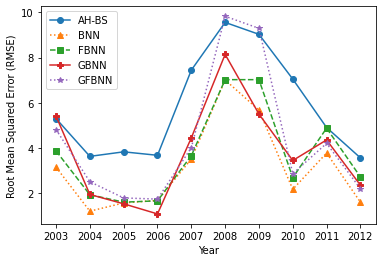

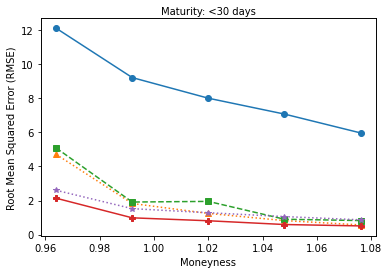

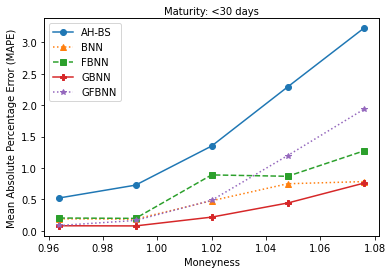

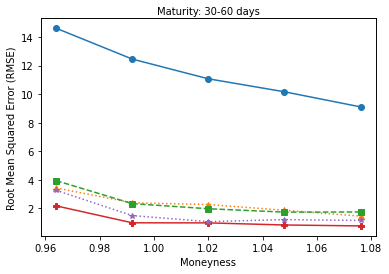

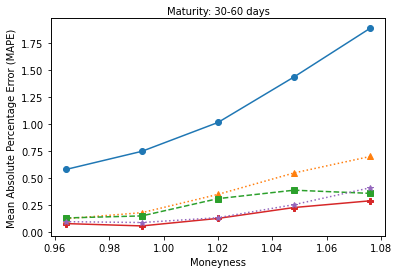

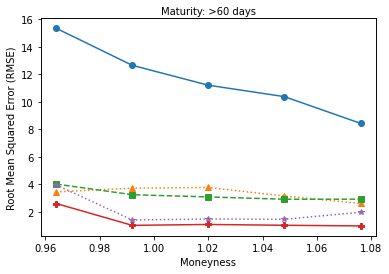

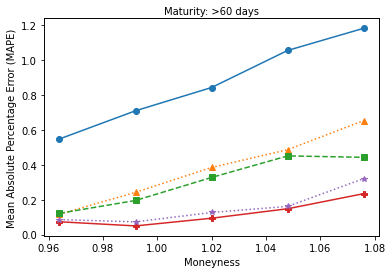

In [ ]:
##FIGURES
#Create Figure 4 from the paper, which plots RMSE against years
years=10
year_vec=np.linspace(2003,2012,years)
rmse_mat=np.zeros([years,estimation_models])
option_data.reset_index()
dates=option_data['numerical_date']
for m in range(0,estimation_models):
  for y in range(0,years):
    year=year_vec[y]
    ind=np.where((dates>year*10**4) & (dates<(year+1)*10**4))
    rmse_mat[y,m]=rmse(market_prices.to_numpy()[ind],estimated_prices[ind,m])

plt.figure(0)
marker = itertools.cycle(('o', '^', 's', 'P', '*','d', 'H')) 
linestyles = itertools.cycle(('solid', 'dotted', 'dashed'))
for m in range(0,estimation_models):
  #plt.plot(year_vec,rmse_mat[:,m])
  plt.plot(year_vec,rmse_mat[:,m],marker=next(marker),linestyle = next(linestyles))
plt.legend(estimation_label)
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xlabel('Year')
plt.xticks(year_vec)
plt.savefig("RMSEyear.eps")
files.download("RMSEyear.eps") 

#Create Figure 5 from the paper, which plots RMSE and MAPE against years
prediction=True

for t in range(0,3):
  dots=5
  moneyness=option_data['moneyness']
  maturity=option_data['maturity']*250
  dates=option_data['numerical_date']
  moneyness_vec=np.linspace(0.95,1.09,dots+1)
  plot_vec=np.ones(dots)
  rmse_mat=np.zeros([dots,estimation_models])
  mape_mat=np.zeros([dots,estimation_models])
  for m in range(0,estimation_models):
    for d in range(0,dots):
        if t==0:
          ind=np.where((moneyness>=moneyness_vec[d]) & (moneyness<=moneyness_vec[d+1]) & (maturity<30))
          if prediction:
            ind=np.where((moneyness>=moneyness_vec[d]) & (moneyness<=moneyness_vec[d+1]) & (maturity<30) & (((dates>=20060700) & (dates<20070000)) | ((dates>=20090700) & (dates<20100000)) | ((dates>=20120700) & (dates<20130000))))
        if t==1:
          ind=np.where((moneyness>=moneyness_vec[d]) & (moneyness<=moneyness_vec[d+1]) & (maturity>=30) & (maturity<=60))
          if prediction:
            ind=np.where((moneyness>=moneyness_vec[d]) & (moneyness<=moneyness_vec[d+1]) & (maturity>=30) & (maturity<=60) & (((dates>=20060700) & (dates<20070000)) | ((dates>=20090700) & (dates<20100000)) | ((dates>=20120700) & (dates<20130000))))
        if t==2:
          ind=np.where((moneyness>=moneyness_vec[d]) & (moneyness<=moneyness_vec[d+1]) & (maturity>60))
          if prediction:
            ind=np.where((moneyness>=moneyness_vec[d]) & (moneyness<=moneyness_vec[d+1]) & (maturity>60) & (((dates>=20060700) & (dates<20070000)) | ((dates>=20090700) & (dates<20100000)) | ((dates>=20120700) & (dates<20130000))))
        if prediction:
          rmse_mat[d,m]=rmse(market_prices.to_numpy()[ind],predicted_prices[ind,m])
          mape_mat[d,m]=mape(market_prices.to_numpy()[ind],predicted_prices[ind,m])
        else:
          rmse_mat[d,m]=rmse(market_prices.to_numpy()[ind],estimated_prices[ind,m])
          mape_mat[d,m]=mape(market_prices.to_numpy()[ind],estimated_prices[ind,m])
        plot_vec[d]=moneyness_vec[d]/2+moneyness_vec[d+1]/2

  if t==0:
    maturity_label="Maturity: <30 days"
    plot_title="Maturity30.eps"
  if t==1:
    maturity_label="Maturity: 30-60 days"
    plot_title="Maturity3060.eps"
  if t==2:
    maturity_label="Maturity: >60 days"
    plot_title="Maturity60.eps"
  plt.figure(1+t*2)
  marker = itertools.cycle(('o', '^', 's', 'P', '*','d', 'H')) 
  linestyles = itertools.cycle(('solid', 'dotted', 'dashed'))
  for m in range(0,estimation_models):
    #plt.plot(plot_vec,rmse_mat[:,m],marker='o')
    plt.plot(plot_vec,rmse_mat[:,m],marker=next(marker),linestyle = next(linestyles))
  #plt.legend(estimation_label)
  plt.ylabel('Root Mean Squared Error (RMSE)')
  plt.xlabel('Moneyness')
  ax2 = plt.twiny()
  ax2.set_xlabel(maturity_label)
  ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False) 
  plt.savefig("RMSE" + plot_title)
  files.download("RMSE" + plot_title)

  plt.figure(2+t*2)
  marker = itertools.cycle(('o', '^', 's', 'P', '*','d', 'H')) 
  linestyles = itertools.cycle(('solid', 'dotted', 'dashed'))
  for m in range(0,estimation_models):
    #plt.plot(plot_vec,mape_mat[:,m],marker='o')
    plt.plot(plot_vec,mape_mat[:,m],marker=next(marker),linestyle = next(linestyles))
  if t==0:
    plt.legend(estimation_label)
  plt.ylabel('Mean Absolute Percentage Error (MAPE)')
  plt.xlabel('Moneyness')
  ax2 = plt.twiny()
  ax2.set_xlabel(maturity_label)
  ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False) 
  plt.savefig("MAPE" + plot_title)
  files.download("MAPE" + plot_title)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

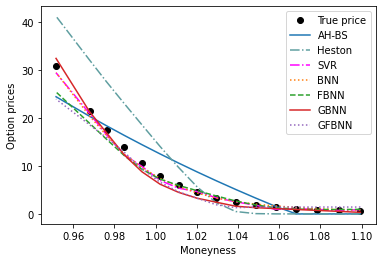

In [ ]:
#Create Figure 3 from the paper, which plots options traded on certain days
moneyness=option_data['moneyness']
maturity=option_data['maturity']*250
dates=option_data['numerical_date']
prices=option_data['market price']
plot_ind=np.where((moneyness>0) & (moneyness<1.1) & (maturity>29) & (maturity<31) & (dates>=20040000) & (dates<20040200))
plt.figure(0)
marker = itertools.cycle(('o', '^', 's', 'P', '*','d', 'H')) 
linestyles = itertools.cycle(('solid', 'dotted', 'dashed'))
moneyness_plot=moneyness.to_numpy()[plot_ind]
prices_plot=prices.to_numpy()[plot_ind]
plt.plot(moneyness_plot,prices_plot,".k", markersize=12)
for m in range(0,estimation_models):
  if not only_plots:
    if m>0 and m<3:
      if m==1:
        plt.plot(moneyness_plot,estimated_prices[plot_ind,m].T,color='cadetblue',linestyle = 'dashdot')
      if m==2:
        plt.plot(moneyness_plot,estimated_prices[plot_ind,m].T,color='magenta',linestyle = 'dashdot')
    else:
      plt.plot(moneyness_plot,estimated_prices[plot_ind,m].T,linestyle = next(linestyles))
  else:
    plt.plot(moneyness_plot,estimated_prices[plot_ind,m].T,linestyle = next(linestyles))
labels=estimation_label.copy()
labels.insert(0,'True price')
plt.legend(labels)
plt.ylabel('Option prices')
plt.xlabel('Moneyness')
plt.savefig("figure3paper.eps")
files.download("figure3paper.eps")

#support vector regression (SVR)

In [ ]:
#This array will have all prices obtained from the
predicted_prices_all=[]
predicted_prices_in_and_out=[]

for i in range(0,3):
  if i==0:
    period='pre-crisis'
  if i==1:
    period='crisis'
  if i==2:
    period='post-crisis'
  if period == 'pre-crisis':
    train = option_data[(option_data['date'] >= pd.Timestamp(2003,1,1)) & (option_data['date'] < pd.Timestamp(2006,7,1))]
    test = option_data[(option_data['date'] >= pd.Timestamp(2006,7,1)) & (option_data['date'] < pd.Timestamp(2007,1,1))]
  elif period == 'crisis':
    train = option_data[(option_data['date'] >= pd.Timestamp(2007,1,1)) & (option_data['date'] < pd.Timestamp(2009,7,1))]
    test = option_data[(option_data['date'] >= pd.Timestamp(2009,7,1)) & (option_data['date'] < pd.Timestamp(2010,1,1))]
  elif period == 'post-crisis':
    train = option_data[(option_data['date'] >= pd.Timestamp(2010,1,1)) & (option_data['date'] < pd.Timestamp(2012,7,1))]
    test = option_data[(option_data['date'] >= pd.Timestamp(2012,7,1)) & (option_data['date'] < pd.Timestamp(2013,1,1))]
  else:
    raise ValueError('Not a valid string for period')

  #Estimate SVR and estimate in sample
  X = train[['moneyness','maturity']].values
  print(np.shape(X)[0])
  X_offset = X.min(0)  # or X.mean(0)
  X_scale = X.max(0) - X_offset  # or X.std(0)
  X_scaled = np.asarray((X - X_offset) / X_scale).astype('float32')
  y = train[['market price']].values.ravel()
  y_offset = y.min(0)  # or X.mean(0)
  y_scale = y.max(0) - y_offset  # or X.std(0)
  y_scaled = np.asarray((y - y_offset) / y_scale).astype('float32')
  C=1
  epsilon=0.0001
  gamma=100000
  start_time=time.perf_counter()
  svr = SVR(kernel='rbf',gamma=gamma,C=C,epsilon=epsilon)
  svr.fit(X_scaled, y_scaled)
  y_pred_svr=svr.predict(X_scaled)
  predicted_prices_in_and_out=np.hstack((predicted_prices_in_and_out,y_pred_svr*y_scale+y_offset))

  #Use SVR to predict out of sample
  X2 = test[['moneyness','maturity']].values
  X2 = np.asarray((X2 - X_offset) / X_scale).astype('float32')
  y2 = test[['market price']].values.ravel()
  y_pred_svr2=svr.predict(X2)
  predicted_prices_in_and_out=np.hstack((predicted_prices_in_and_out,y_pred_svr2*y_scale+y_offset))

  #Use SVR for full sample
  all=pd.concat((train,test))
  X = all[['moneyness','maturity']].values
  X_offset = X.min(0)  # or X.mean(0)
  X_scale = X.max(0) - X_offset  # or X.std(0)
  X_scaled = np.asarray((X - X_offset) / X_scale).astype('float32')
  y_all = all[['market price']].values.ravel()
  y_all_offset = y_all.min(0)  # or X.mean(0)
  y_all_scale = y_all.max(0) - y_all_offset  # or X.std(0)
  y_all_scaled = np.asarray((y_all - y_all_offset) / y_all_scale).astype('float32')
  svr = SVR(kernel='rbf',gamma=gamma,C=C,epsilon=epsilon)
  svr.fit(X_scaled, y_all_scaled)
  y_pred_all=svr.predict(X_scaled)
  predicted_prices_all=np.hstack((predicted_prices_all,y_pred_all*y_all_scale+y_all_offset))

  end_time=time.perf_counter()
  mape_in=np.mean(np.divide(np.abs(y_pred_svr*y_scale+y_offset-y),y))
  rmse_in=np.sqrt(np.mean((((y_pred_svr*y_scale+y_offset-y)**2))))
  mape_out=np.mean(np.divide(np.abs(y_pred_svr2*y_scale+y_offset-y2),y2))
  rmse_out=np.sqrt(np.mean((((y_pred_svr2*y_scale+y_offset-y2)**2))))

  print(period + " MAPE SVR in sample: " + str(mape_in))
  print(period + " RMSE SVR in sample: " + str(rmse_in))
  print(period + " MAPE SVR out sample: " + str(mape_out))
  print(period + " RMSE SVR out sample: " + str(rmse_out))
  print("time " + str(end_time-start_time))

savetxt('svr_estimation.csv', predicted_prices_all, delimiter=',')
files.download("svr_estimation.csv")
savetxt('svr_prediction.csv', predicted_prices_in_and_out, delimiter=',')
files.download("svr_prediction.csv")

31071
time for 1 option: 0.0012265719999504654


# least-squares Monte Carlo - Heston (LSM-Heston)

This contains the steps seperately for testing, the full object oriented, commented code is in Class Heston


1. Calibration step 1: kappa, eta and theta through indirect inference

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3462.47596844589
Iteration:      2,   Func. Count:     14,   Neg. LLF: 3458.646757984434
Iteration:      3,   Func. Count:     21,   Neg. LLF: 3455.859327648929
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3450.870556079545
Iteration:      5,   Func. Count:     35,   Neg. LLF: 3449.145363910649
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3448.8051177015723
Iteration:      7,   Func. Count:     49,   Neg. LLF: 3448.1827463598693
Iteration:      8,   Func. Count:     56,   Neg. LLF: 3447.0710740955765
Iteration:      9,   Func. Count:     63,   Neg. LLF: 3446.713657325886
Iteration:     10,   Func. Count:     70,   Neg. LLF: 3446.562163754563
Iteration:     11,   Func. Count:     76,   Neg. LLF: 3446.5546469463197
Iteration:     12,   Func. Count:     82,   Neg. LLF: 3446.5483619396427
Iteration:     13,   Func. Count:     88,   Neg. LLF: 3446.5483371389428
Optimization terminated successfully.    (Exit mode 0)
    

KeyboardInterrupt: ignored

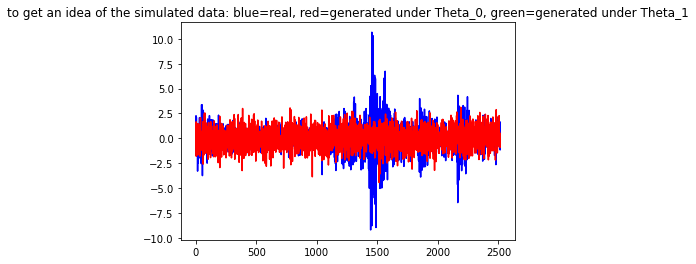

In [ ]:
## Part 1: find kappa, eta and theta through indirect inference, as described in section 4.1 of AitSahlia ################################################################
min_date=20030101
max_date=20121231
underlying_data=underlying_data[(underlying_data['numerical_date'] >= min_date) & (underlying_data['numerical_date'] <= max_date)]

#Calculate (log) returns
S=underlying_data["close"].to_numpy()
S_lag=shift(S,1,cval=np.NaN)
r=np.log(np.divide(S,S_lag))*100
r=r[1:]

#Fit garch model to find ksi (the conditional kurtosis) (from page 345 in Engle and Lee (chapter 11))
garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1, dist='t')
model_fit = garch_model.fit()
nu=model_fit.params.to_numpy()[3]
ksi=3*(nu-2)/(nu-4)

#Fit garch model to calculate Gamma_0
garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = garch_model.fit()
Gamma_0=model_fit.params.to_numpy()
omega=Gamma_0[0]
alpha=Gamma_0[1]
beta=Gamma_0[2]
print("for Gamma0: omega: " + str(omega) + "(3*10^-7) alpha: " + str(alpha) + "(0.04) beta: " + str(beta) + "(0.95), numbers in brackets are from AitSahlia")

#Set parameters as in AitSahlia page 195, equation 9, where we discretize time to 5 minutes
N=len(r)
discretizations=77
tau=(1/discretizations)
kappa_0=Gamma_0[0]/tau
theta_0=(1-Gamma_0[1]-Gamma_0[2])/tau
eta_0=Gamma_0[1]*np.sqrt((ksi-1)*tau) #Not there is a mistake in equation 9 in AitSahlia
epsilon1=np.random.normal(0,1,[N*discretizations,1])
epsilon2=np.random.normal(0,1,[N*discretizations,1])
print("for Theta0: kappa: " + str(kappa_0) + "(0.0044) theta: " + str(theta_0) + "(6.93*10^-5) eta: " + str(eta_0) + "(0.0653), numbers in brackets are from AitSahlia")

#Function that generates data that follows the Heston model
def generate_Heston(k_0,theta_0,eta_0,N,discretizations,tau,epsilon1,epsilon2):
    r_gen=np.zeros([N,1])
    v_0=0.187377 #Taken from AitSahlia
    v_gen_dis=np.zeros([N*discretizations,1])
    for t in range(0,N*discretizations):
        if t==0:
            v_gen_dis[t]=k_0*theta_0*tau+(1-k_0*tau)*v_0+eta_0*np.sqrt(tau*v_0)*epsilon2[t]
        else:
            v_gen_dis[t]=k_0*theta_0*tau+(1-k_0*tau)*v_gen_dis[t-1]+eta_0*np.sqrt(tau*v_gen_dis[t-1])*epsilon2[t]
        if v_gen_dis[t]<0:
            v_gen_dis[t]=-v_gen_dis[t]
    r_gen_dis=np.multiply(np.sqrt(v_gen_dis*tau),epsilon1)
    for n in range(0,N):
      r_gen[n]=np.sum(r_gen_dis[n*discretizations:(n+1)*discretizations])
    return r_gen

r_gen=generate_Heston(kappa_0,theta_0,eta_0,N,discretizations,tau,epsilon1,epsilon2)

#Fit garch model to calculate Gamma_1 
garch_model=arch.arch_model(r_gen, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = garch_model.fit()
Gamma_1=model_fit.params.to_numpy()

plt.title('to get an idea of the simulated data: blue=real, red=generated under Theta_0, green=generated under Theta_1')
plt.plot(r,'b')
plt.plot(r_gen,'r')

#Fit garch model with fixed parameters Gamma_1 
garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1)
fixed_fit=garch_model.fix(Gamma_1)
conVol = fixed_fit.conditional_volatility
resid = fixed_fit.resid

#Function that calculates omega matrix, as in AitSahlia page 195 (where entries correspond to derivatives)
def create_matrix(omega,alpha,beta,resid,conVol,r,N):
    for t in range(1,N):
        entry1=-1/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
        entry2=-(resid[t-1]**2)/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)*(resid[t-1]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
        entry3=-conVol[t-1]/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)*conVol[t-1]/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
        vec=[[entry1],[entry2],[entry3]]
        if t==1:
            sum=np.matmul(vec,np.transpose(vec))
        else:
            sum=sum+np.matmul(vec,np.transpose(vec))
    return scipy.linalg.inv((1/N)*sum)

omega=Gamma_1[0]
alpha=Gamma_1[1]
beta=Gamma_1[2]
print("for Gamma1: omega: " + str(omega) + "(4*10^-9) alpha: " + str(alpha) + "(0.45) beta: " + str(beta) + "(0.55), numbers in brackets are from AitSahlia")
Omega=create_matrix(omega,alpha,beta,resid,conVol,r,N)

#Function that calculates the criterium as in AitSahlia page 196, equation 11, using m from equation 10 (where entries correspond to derivatives)
def OptFun(Theta_1,Gamma_1,Omega,omega,alpha,beta,N,discretizations,tau):
    m=np.array([0, 0, 0])
    kappa=Theta_1[0]
    theta=Theta_1[1]
    eta=Theta_1[2]
    r_gen=generate_Heston(kappa,theta,eta,N,discretizations,tau,epsilon1,epsilon2)
    garch_model=arch.arch_model(r_gen, mean='Zero', vol='GARCH', p=1, q=1)
    fixed_fit=garch_model.fix(Gamma_1)
    conVol = fixed_fit.conditional_volatility
    resid = fixed_fit.resid
    for t in range(1,N):
        m[0]=m[0]-1/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r_gen[t]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
        m[1]=m[1]-(resid[t-1]**2)/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r_gen[t]**2)*(resid[t-1]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
        m[2]=m[2]-conVol[t-1]/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r_gen[t]**2)*conVol[t-1]/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
    m=m/N
    result=np.matmul(m.T,np.matmul(Omega,m))
    return result
    
res=scipy.optimize.minimize(OptFun,x0=[kappa_0,theta_0,eta_0],args=(Gamma_1,Omega,omega,alpha,beta,N,discretizations,tau),bounds=((0, None),(0, None),(0, None)))

#This solution should be the final parameters kappa, theta, eta
solution=res.x
kappa=solution[0]
theta=solution[1]
eta=solution[2]
print("Final solution: kappa: " + str(kappa) + "(2.65) theta: " + str(theta) + "(0.029) eta: " + str(eta) + "(0.154), numbers in brackets are from AitSahlia")
print("Note the values are not similar, especially theta")
r_gen_final=generate_Heston(kappa,theta,eta,N,discretizations,tau,epsilon1,epsilon2)
plt.plot(r_gen_final,'g')

2. Calibration step 2: v, lamda, rho through minimizing error of european options

In [ ]:
## Part 2: find v, lamda, rho through minimizing squared pricing error ################################################################

#Use paramters found in step 1
k_1=kappa
theta_1=theta
eta_1=eta
Theta_1=[k_1,theta_1,eta_1]

#Functions necessary to find the put price, as in AitSahlia equation 4, index refers to j=1 or j=2
def put_price(K,x,v,T,r,kappa,theta,eta,lamda,rho):
    call_price=calcFFT(x,K,r,T,v,kappa,theta,eta,lamda,rho)
    #Use put call parity
    return call_price+K*np.exp(-r*T)-x

def calcFFT(x,K,r,T,v,kappa,theta,eta,lamda,rho):
    alpha = 4
    N=2**12
    Upperlimit=1000
    etaa=Upperlimit/N
    lambdaFFT=(2*np.pi)/(N*etaa)
    b=N*lambdaFFT/2
    u=np.linspace(0,N-1,N)*etaa
    KGrid = -b+lambdaFFT*np.linspace(0,N-1,N)
    help_vec=np.zeros([N])
    help_vec[0]=1
    #Carr-Madan Equation
    Psi=np.exp(-r*T)*np.divide(HestonCF(u-(alpha+1)*complex(0,1),x,r,T,v,kappa,theta,eta,rho,lamda),(alpha**2+alpha-np.multiply(u,u)+complex(0,1)*(2*alpha+1)*u))
    Function=np.multiply(np.exp(complex(0,1)*b*u),np.multiply(Psi,((etaa/3)*(3+np.power(-1,np.linspace(1,N,N))-help_vec))))
    FastFourierPriceGrid=(np.exp(-KGrid*alpha)/np.pi)*np.real(np.fft.fft(Function))
    SpotOnGrid = (np.log(K)+b)/lambdaFFT+1
    return (1-(SpotOnGrid-np.floor(SpotOnGrid)))*FastFourierPriceGrid[int(np.floor(SpotOnGrid))-1]+(SpotOnGrid-np.floor(SpotOnGrid))*FastFourierPriceGrid[int(np.floor(SpotOnGrid))]
    
def HestonCF(Phi,S0,r,T,V0,kappa,theta,sigma,rho,lamda):
    a=kappa*theta
    u=-0.5
    b = kappa+lamda
    d=np.sqrt((rho*sigma*complex(0,1)*Phi-b)**2-sigma**2*(2*u*complex(0,1)*Phi-Phi**2))
    g=(b-rho*sigma*complex(0,1)*Phi-d)/(b-rho*sigma*complex(0,1)*Phi+d)
    D=(b-rho*sigma*complex(0,1)*Phi-d)/(sigma**2*(1-np.exp(-d*T))/(1-g*np.exp(-d*T)))
    C=r*complex(0,1)*Phi*T+(a/(sigma**2))*((b-rho*sigma*complex(0,1)*Phi-d)*T-2*np.log(((1-g*np.exp(-d*T))/(1-g))))            
    return_value=np.exp(C+D*V0+complex(0,1)*Phi*np.log(S0))
    return return_value

#function that defines optimization criterium
def sum_squared_error(params,day_data,kappa,theta,eta):
    #print('calculating SSE')
    v=params[0]
    rho=params[1]
    lamda=0
    SSE=0
    for index, row in day_data.iterrows():
        real_price=row['market price']
        estimated_price=put_price(row['strike_price'],row['underlying'],v,row['maturity'],0,kappa,theta,eta,lamda,rho)
        SSE=SSE+(real_price-estimated_price)**2
    if (math.isnan(SSE)):
        SSE=10**20
    return SSE

#Optimize parameters for every trading day
date_vec=option_data_european["date"].to_numpy()
days=len(set(option_data_european["date"].to_numpy()))
days=10
v_vec=np.zeros([days,1])
rho_vec=np.zeros([days,1])
lamda_vec=np.zeros([days,1])
day_selector=0

for day in range(0,days):
    if (day%1==0):
      print("day: " + str(day) + " of " + str(days-1))
    
    #Set initial parameters
    if day==0:
        date=date_vec[day_selector]
        v0=0.0349
        rho0=-0.487
        lamda0=2.14 
    else:
        while (date_vec[day_selector]==prev_date):
            day_selector=day_selector+1
        date=date_vec[day_selector]
        v0=v_vec[day-1]
        rho0=rho_vec[day-1]
        lamda0=lamda_vec[day-1]
    params0=[v0,rho0,lamda0]
    
    #select the correct options
    day_data = option_data_european[(option_data_european['date']==date)]
    #Minimize for these options
    res=scipy.optimize.minimize(sum_squared_error,x0=[v0,rho0],args=(day_data,k_1,theta_1,eta_1),bounds=((0, 1),(-0.8,0.8)),options={'maxiter': 20})
    solution=res.x
    v_vec[day]=solution[0]
    rho_vec[day]=solution[1]
    #lamda_vec[day]=solution[2]
    prev_date=date

#This solution should be the final parameters v, rho, lamda     
v=np.mean(v_vec)
rho=np.mean(rho_vec)
print("v: " + str(v) + "(0.03) rho: " + str(rho) + "(-0.49), numbers in brackets are from AitSahlia")
#No MAXITER on full sample: v: 0.0022569100134651613(0.03) rho: -0.3812581643813785(-0.49), numbers in brackets are from AitSahlia 

day: 0 of 9
day: 1 of 9


KeyboardInterrupt: ignored

2. Pricing step: price american options, using the calibrated model


In [ ]:
#### part 3
def L0(X):
  return np.exp(-X/2)
def L1(X):
  return np.multiply(np.exp(-X/2),(1-X))
def L2(X):
  return (1/2)*np.multiply(np.exp(-X/2),(np.multiply(X,X)-4*X+2))

max_vec=np.vectorize(max,otypes=[np.float64])

#parameters of heston model
v=0.0349
rho=-0.487
lamda=0
kappa=0.023 #(2.65)
theta=0.018 #(0.029)
eta=0.277   #(0.154)
print(2*kappa*theta-eta**2)
N=1000 #amount of paths (100000)
m=50

epsilon=np.random.multivariate_normal([0,0],[[1,rho],[rho,1]],[m,N])

def generate_Heston_matrix(v_0,rho,lamda,kappa,theta,eta,m,N,S_0,h,epsilon):
    S_paths=np.zeros([N,m])
    #Multiply epsilon by h to deal with the timestep
    epsilon=epsilon*np.sqrt(h)
    v_0=v_0*np.ones([1,N])
    for ti in range(0,m):
        if ti==0:
            v=kappa*theta+(1-kappa)*v_0+eta*np.sqrt(v_0)*epsilon[ti,:,1]
            v=abs(v)
            S=np.exp(np.multiply(np.sqrt(v),epsilon[ti,:,0]))*S_0
            S_paths[:,ti]=S
        else:
            v=kappa*theta+(1-kappa)*v+eta*np.sqrt(v)*epsilon[ti,:,1]
            v=abs(v)
            S=np.exp(np.multiply(np.sqrt(v),epsilon[ti,:,0]))*S_0
            S_paths[:,ti]=S
    return S_paths

def price_option_LSM(S_0,K,maturity,r,epsilon):
    #I'm not exactly sure how to handle the timestep
    h=maturity/m

    #simulate path
    S_paths=generate_Heston_matrix(v,rho,lamda,kappa,theta,eta,m,N,S_0,h,epsilon)
   
    start_cashflow_time=time.perf_counter() 
    #create matrix of cashflows, and matrix of discount rates

    cashflow_matrix=np.zeros([N,m])
    discount_matrix=np.ones([N,m])
    for ti in range(0,m):
        discount_matrix[:,ti]=discount_matrix[:,ti]*np.exp(-r*ti)    
    cashflow_matrix[:,m-1]=max_vec(K-S_paths[:,m-1],0)

    #recursively calculate the cashflows
    for ti in range(m-2,-1,-1):
        exercise_value=max_vec(K-S_paths[:,ti],0)
        #calculate continuation value by regressing in the money options
        itm_indices=np.where(exercise_value > 0)[0]
        if (np.shape(itm_indices)[0]>0):
          Y=np.matmul(np.multiply(cashflow_matrix,discount_matrix),np.ones([m,1]))
          X=np.column_stack([np.zeros([N,1]),L0(S_paths[:,ti]),L1(S_paths[:,ti]),L2(S_paths[:,ti])])
          end_Xregression_matrix_time=time.perf_counter()
          Y_itm=Y[itm_indices]
          X_itm=X[itm_indices,:]
          beta=np.linalg.lstsq(np.matmul(X_itm.T,X_itm),np.matmul(X_itm.T,Y_itm),rcond=1)[0]
          continuation_value=np.matmul(X,beta)
          exercise_indices=np.where((exercise_value>continuation_value[0,:])*1 == 1)[0]
          cashflow_matrix[exercise_indices,:]=np.zeros([len(exercise_indices),m])
          cashflow_matrix[exercise_indices,ti]=exercise_value[exercise_indices]

    #the option price is the mean of the discounted cashflows
    option_value=np.mean(np.matmul(np.multiply(cashflow_matrix,discount_matrix),np.ones([m,1])))
    return option_value

#Price the options
i=0
rows=np.shape(option_data)[0]

amount=10000
mape=0
total_time=0
for index, row in option_data.iterrows():
  i=i+1
  if (i>amount):
    break
  if (i%(amount/10)==0):
    print(i)
  start_price_time=time.perf_counter() 
  estimated_option_value=price_option_LSM(row["underlying"],row["strike_price"],row["maturity"],row["interest_rate"]/250,epsilon)
  end_price_time=time.perf_counter() 
  total_time=total_time+end_price_time-start_price_time
  #print("Time to price option: " + str(end_price_time-start_price_time))
  true_option_value=row["market price"]
  #print("underlying: "  + str(row["underlying"]) + " strike: " + str(row["strike_price"]) + " maturity: " + str(row["maturity"]))
  #print("estimated: "  + str(estimated_option_value) + " true: " + str(true_option_value))
  mape=mape+(1/amount)*(np.abs(estimated_option_value-true_option_value)/true_option_value)
print("MAPE: " + str(mape))
print("total time: " + str(total_time) + ", time per option: " + str(total_time/amount))

-0.07590100000000002
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
MAPE: 0.8084202129298442
total time: 413.88203647086993, time per option: 0.041388203647086994


0.806167

# Class Heston

In [ ]:
class HestonModel():
    
    def __init__(self,
                 option_data_european,
                 underlying_data):
        
        self.underlying_data=underlying_data
        self.option_data_european=option_data_european
                 
    def calibrate_structural(self):
       '''
       First step of heston calibration, calculates kappa, theta and eta
       '''
        min_date=20030101
        max_date=20121231
        self.underlying_data=self.underlying_data[(self.underlying_data['numerical_date'] >= min_date) & (self.underlying_data['numerical_date'] <= max_date)]
        
        #Calculate (log) returns
        S=self.underlying_data["close"].to_numpy()
        S_lag=shift(S,1,cval=np.NaN)
        r=np.log(np.divide(S,S_lag))*100
        r=r[1:]

        plt.plot(r, 'b')

        #Fit garch model to find ksi (the conditional kurtosis) (from page 345 in Engle and Lee (chapter 11))
        garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1, dist='t')
        model_fit = garch_model.fit(disp="off")
        nu=model_fit.params.to_numpy()[3]
        ksi=3*(nu-2)/(nu-4)
        
        #Fit garch model to calculate Gamma_0
        garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1)
        model_fit = garch_model.fit(disp="off")
        Gamma_0=model_fit.params.to_numpy()
        omega=Gamma_0[0]
        alpha=Gamma_0[1]
        beta=Gamma_0[2]
        print("for Gamma0: omega: " + str(omega) + "(3*10^-7) alpha: " + str(alpha) + "(0.04) beta: " + str(beta) + "(0.95), numbers in brackets are from AitSahlia")
        
        #Set parameters as in AitSahlia page 195, equation 9, where we discretize time to 5 minutes
        N=len(r)
        discretizations=1
        tau=(1/discretizations)
        kappa_0=Gamma_0[0]/(1-Gamma_0[1]-Gamma_0[2])
        theta_0=(1-Gamma_0[1]-Gamma_0[2])/tau
        eta_0=Gamma_0[1]*np.sqrt((ksi-1)*tau) #Note there is a mistake in equation 9 in AitSahlia
        print("for Theta0: kappa: " + str(kappa_0) + "(0.0044) theta: " + str(theta_0) + "(6.93*10^-5) eta: " + str(eta_0) + "(0.0653), numbers in brackets are from AitSahlia")
        epsilon1=np.random.normal(0,1,[N*discretizations,1])
        epsilon2=np.random.normal(0,1,[N*discretizations,1])           
        r_gen=self.generate_Heston(kappa_0,theta_0,eta_0,N,discretizations,tau,epsilon1,epsilon2)

        plt.plot(r_gen,'r')

        #Fit garch model to calculate Gamma_1 
        garch_model=arch.arch_model(r_gen, mean='Zero', vol='GARCH', p=1, q=1)
        model_fit = garch_model.fit(disp="off")
        Gamma_1=model_fit.params.to_numpy()
        
        #Fit garch model with fixed parameters Gamma_1 
        garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1)
        fixed_fit=garch_model.fix(Gamma_1)
        conVol = fixed_fit.conditional_volatility
        resid = fixed_fit.resid            
        omega=Gamma_1[0]
        alpha=Gamma_1[1]
        beta=Gamma_1[2]
        print("for Gamma1: omega: " + str(omega) + "(4*10^-9) alpha: " + str(alpha) + "(0.45) beta: " + str(beta) + "(0.55), numbers in brackets are from AitSahlia")
        Omega=self.create_matrix(omega,alpha,beta,resid,conVol,r,N)
            
        epsilon1=np.random.normal(0,1,[N*discretizations,1])
        epsilon2=np.random.normal(0,1,[N*discretizations,1])  
      
        res=scipy.optimize.minimize(self.OptFun,x0=[kappa_0,theta_0,eta_0],args=(Gamma_1,Omega,omega,alpha,beta,N,discretizations,tau,epsilon1,epsilon2),bounds=((0, None),(0, 2),(0, 2)))
        #This solution should be the final parameters kappa, theta, eta
        solution=res.x
        kappa=solution[0]
        theta=solution[1]
        eta=solution[2]
        print("Final solution=Theta1: kappa: " + str(kappa) + "(2.65) theta: " + str(theta) + "(0.029) eta: " + str(eta) + "(0.154), numbers in brackets are from AitSahlia")
        return solution
                    
    #Function that generates data that follows the Heston model
    def generate_Heston(self,k_0,theta_0,eta_0,N,discretizations,tau,epsilon1,epsilon2):
      '''
      Generates data according to the Heston model
      '''
        r_gen=np.zeros([N,1])
        v_0=0.187377 #Taken from AitSahlia
        v_gen_dis=np.zeros([N*discretizations,1])
        for t in range(0,N*discretizations):
            if t==0:
                v_gen_dis[t]=k_0*theta_0*tau+(1-k_0*tau)*v_0+eta_0*np.sqrt(tau*v_0)*epsilon2[t]
            else:
                v_gen_dis[t]=k_0*theta_0*tau+(1-k_0*tau)*v_gen_dis[t-1]+eta_0*np.sqrt(tau*v_gen_dis[t-1])*epsilon2[t]
            if v_gen_dis[t]<0:
                v_gen_dis[t]=-v_gen_dis[t]
        r_gen_dis=np.multiply(np.sqrt(v_gen_dis*tau),epsilon1)
        for n in range(0,N):
          r_gen[n]=np.sum(r_gen_dis[n*discretizations:(n+1)*discretizations])
        return r_gen    
    
    #Function that calculates omega matrix, as in AitSahlia page 195 (where entries correspond to derivatives)
    def create_matrix(self,omega,alpha,beta,resid,conVol,r,N):
      '''
      Creates Omega matrix
      '''
        for t in range(1,N):
            entry1=-1/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
            entry2=-(resid[t-1]**2)/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)*(resid[t-1]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
            entry3=-conVol[t-1]/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)*conVol[t-1]/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
            vec=[[entry1],[entry2],[entry3]]
            if t==1:
                sum=np.matmul(vec,np.transpose(vec))
            else:
                sum=sum+np.matmul(vec,np.transpose(vec))
        return scipy.linalg.inv((1/N)*sum)
    
    #Function that calculates the criterium as in AitSahlia page 196, equation 11, using m from equation 10 (where entries correspond to derivatives)
    def OptFun(self,Theta_1,Gamma_1,Omega,omega,alpha,beta,N,discretizations,tau,epsilon1,epsilon2):
      '''
      Optimization criterium
      '''
        m=np.array([0, 0, 0])
        kappa=Theta_1[0]
        theta=Theta_1[1]
        eta=Theta_1[2]
        r_gen=self.generate_Heston(kappa,theta,eta,N,discretizations,tau,epsilon1,epsilon2)
        garch_model=arch.arch_model(r_gen, mean='Zero', vol='GARCH', p=1, q=1)
        fixed_fit=garch_model.fix(Gamma_1)
        conVol = fixed_fit.conditional_volatility
        resid = fixed_fit.resid

        resid_lag=shift(resid,1,cval=np.NaN)
        resid=resid_lag[1:]
        conVol_lag=shift(conVol,1,cval=np.NaN)
        conVol=conVol_lag[1:]
        r_gen=r_gen[1:]
        
        m[0]=np.sum(-1/(omega+alpha*np.square(resid)+beta*conVol)+np.divide(np.square(r_gen),2*np.square(omega+alpha*np.square(resid)+beta*conVol)))
        m[1]=np.sum(-np.divide(np.square(resid),(omega+alpha*np.square(resid)+beta*conVol))+np.divide(np.multiply(np.square(r_gen),np.square(resid)),2*np.square(omega+alpha*np.square(resid)+beta*conVol)))
        m[2]=np.sum(-np.divide(conVol,(omega+alpha*np.square(resid)+beta*conVol))+np.divide(np.multiply(np.square(r_gen),conVol),2*np.square(omega+alpha*np.square(resid)+beta*conVol)))
        m=m/N
        result=np.matmul(m.T,np.matmul(Omega,m))
        return result
    
    def calibrate_european(self,params):
       '''
       Second step of heston calibration, calculates kappa, theta and eta
       '''
        k_1=params[0]
        theta_1=params[1]
        eta_1=params[2]
        #Optimize parameters for every trading day
        date_vec=self.option_data_european["date"].to_numpy()
        days=len(set(self.option_data_european["date"].to_numpy()))
        v_vec=np.zeros([days,1])
        rho_vec=np.zeros([days,1])
        day_selector=0
        
        bound=0.999

        for day in range(0,days):
            if day==10:
              print(rho_vec[0:day])
            if (day%100==0):
              print("day: " + str(day) + " of " + str(days-1))
              
            #Set initial parameters
            if day==0:
                date=date_vec[day_selector]
                v0=0.0349
                rho0=-0.487
            else:
                while (date_vec[day_selector]==prev_date):
                    day_selector=day_selector+1
                date=date_vec[day_selector]
                v0=v_vec[day-1]
                rho0=rho_vec[day-1]
                if abs(rho0)==bound:
                  rho0=-0.487
            
            #select the correct options
            day_data = self.option_data_european[(option_data_european['date']==date)]
            #Minimize for these options
            res=scipy.optimize.minimize(self.sum_squared_error,x0=[v0,rho0],args=(day_data,k_1,theta_1,eta_1),bounds=((0, 1),(-1*bound,bound)),options={'maxiter': 20})
            solution=res.x
            v_vec[day]=solution[0]
            rho_vec[day]=solution[1]
            prev_date=date
        
        #This solution should be the final parameters v, rho, lamda     
        v=np.mean(v_vec)
        rho=np.mean(rho_vec)
        print("table information for v: mean: " + str(np.mean(v_vec)) + " median: " + str(np.median(v_vec)) + " sd: " + str(np.std(v_vec)) + " min: " + str(min(v_vec)) + " max: " + str(max(v_vec)))
        print("table information for rho: mean: " + str(np.mean(rho_vec)) + " median: " + str(np.median(rho_vec)) + " sd: " + str(np.std(rho_vec)) + " min: " + str(min(rho_vec)) + " max: " + str(max(rho_vec)))
        print("v: " + str(v) + "(0.03) rho: " + str(rho) + "(-0.49), numbers in brackets are from AitSahlia")
        return np.array([v,rho])
        
    def put_price(self,K,x,v,T,r,kappa,theta,eta,lamda,rho):
       '''
       Calculate put option price using put call parity
       '''
        call_price=self.calcFFT(x,K,r,T,v,kappa,theta,eta,lamda,rho)
        #Use put call parity
        return call_price+K*np.exp(-r*T)-x
    
    def calcFFT(self,x,K,r,T,v,kappa,theta,eta,lamda,rho):
      '''
      Calculate call price using FFT, adopted code from Financial engineering course
      '''
        alpha = 4
        N=2**12
        Upperlimit=1000
        etaa=Upperlimit/N
        lambdaFFT=(2*np.pi)/(N*etaa)
        b=N*lambdaFFT/2
        u=np.linspace(0,N-1,N)*etaa
        KGrid = -b+lambdaFFT*np.linspace(0,N-1,N)
        help_vec=np.zeros([N])
        help_vec[0]=1
        #Carr-Madan Equation
        Psi=np.exp(-r*T)*np.divide(self.HestonCF(u-(alpha+1)*complex(0,1),x,r,T,v,kappa,theta,eta,rho,lamda),(alpha**2+alpha-np.multiply(u,u)+complex(0,1)*(2*alpha+1)*u))
        Function=np.multiply(np.exp(complex(0,1)*b*u),np.multiply(Psi,((etaa/3)*(3+np.power(-1,np.linspace(1,N,N))-help_vec))))
        FastFourierPriceGrid=(np.exp(-KGrid*alpha)/np.pi)*np.real(np.fft.fft(Function))
        SpotOnGrid = (np.log(K)+b)/lambdaFFT+1
        return (1-(SpotOnGrid-np.floor(SpotOnGrid)))*FastFourierPriceGrid[int(np.floor(SpotOnGrid))-1]+(SpotOnGrid-np.floor(SpotOnGrid))*FastFourierPriceGrid[int(np.floor(SpotOnGrid))]
    
    def HestonCF(self,Phi,S0,r,T,V0,kappa,theta,sigma,rho,lamda):
      '''
      Calculate Heston characteristic function, adopted code from Financial engineering course
      '''
        a=kappa*theta
        u=-0.5
        b = kappa+lamda
        d=np.sqrt((rho*sigma*complex(0,1)*Phi-b)**2-sigma**2*(2*u*complex(0,1)*Phi-Phi**2))
        g=(b-rho*sigma*complex(0,1)*Phi-d)/(b-rho*sigma*complex(0,1)*Phi+d)
        D=(b-rho*sigma*complex(0,1)*Phi-d)/(sigma**2*(1-np.exp(-d*T))/(1-g*np.exp(-d*T)))
        C=r*complex(0,1)*Phi*T+(a/(sigma**2))*((b-rho*sigma*complex(0,1)*Phi-d)*T-2*np.log(((1-g*np.exp(-d*T))/(1-g))))            
        return_value=np.exp(C+D*V0+complex(0,1)*Phi*np.log(S0))
        return return_value
    
    #function that defines optimization criterium
    def sum_squared_error(self,params,day_data,kappa,theta,eta):
      '''
      Calculate sum of squared errors, which is used as an optimization criterium
      '''
        #print('calculating SSE')
        v=params[0]
        rho=params[1]
        lamda=0
        SSE=0
        for index, row in day_data.iterrows():
            real_price=row['market price']
            estimated_price=self.put_price(row['strike_price'],row['underlying'],v,row['maturity'],0,kappa,theta,eta,lamda,rho)
            SSE=SSE+(real_price-estimated_price)**2
        if (math.isnan(SSE)):
            SSE=10**20
        return SSE
    
    def calibrate(self):
      '''
      Wrapper function for all calibration
      '''
        print("Calibrating structural parameters")
        Theta1=self.calibrate_structural()
        print("Calibrating on European options")
        Par=self.calibrate_european(Theta1)
        Params=np.array([Theta1[0],Theta1[1],Theta1[2],Par[0],Par[1]])
        print(Params)
        return Params
    
    #Laguerre polynomials
    def L0(self,X):
      '''
      Laguerre polynomial 0
      '''
        return np.exp(-X/2)
    def L1(self,X):
      '''
      Laguerre polynomial 1
      '''
        return np.multiply(np.exp(-X/2),(1-X))
    def L2(self,X):
      '''
      Laguerre polynomial 2
      '''
        return (1/2)*np.multiply(np.exp(-X/2),(np.multiply(X,X)-4*X+2))
    
    def generate_Heston_matrix(self,v_0,rho,kappa,theta,eta,m,N,S_0,h,epsilon):
      '''
      Generate heston data, which is vectorized as far as possible (hard to do due to the time dependence)
      '''
        S_paths=np.zeros([N,m])
        #Multiply epsilon by h to deal with the timestep
        epsilon=epsilon*np.sqrt(h)
        v_0=v_0*np.ones([1,N])
        for ti in range(0,m):
            if ti==0:
                v=kappa*theta+(1-kappa)*v_0+eta*np.sqrt(v_0)*epsilon[ti,:,1]
                v=abs(v)
                S=np.exp(np.multiply(np.sqrt(v),epsilon[ti,:,0]))*S_0
                S_paths[:,ti]=S
            else:
                v=kappa*theta+(1-kappa)*v+eta*np.sqrt(v)*epsilon[ti,:,1]
                v=abs(v)
                S=np.exp(np.multiply(np.sqrt(v),epsilon[ti,:,0]))*S_0
                S_paths[:,ti]=S
        return S_paths
    
    def price_option_LSM(self,S_0,K,maturity,r,epsilon,params,m,N):
      '''
      Price options with Heston using the least squares Monte Carlo algorithm by Longstaff and Schwartz
      '''
        kappa=params[0]
        theta=params[1]
        eta=params[2]
        v=params[3]
        rho=params[4]
        h=maturity/m
        max_vec=np.vectorize(max,otypes=[np.float64])
        #simulate path
        S_paths=self.generate_Heston_matrix(v,rho,kappa,theta,eta,m,N,S_0,h,epsilon)
       
        #create matrix of cashflows, and matrix of discount rates
        cashflow_matrix=np.zeros([N,m])
        discount_matrix=np.ones([N,m])
        for ti in range(0,m):
            discount_matrix[:,ti]=discount_matrix[:,ti]*np.exp(-r*ti)    
        cashflow_matrix[:,m-1]=max_vec(K-S_paths[:,m-1],0)
    
        #recursively calculate the cashflows
        for ti in range(m-2,-1,-1):
            exercise_value=max_vec(K-S_paths[:,ti],0)
            #calculate continuation value by regressing in the money options
            itm_indices=np.where(exercise_value > 0)[0]
            if (np.shape(itm_indices)[0]>0):
              Y=np.matmul(np.multiply(cashflow_matrix,discount_matrix),np.ones([m,1]))
              X=np.column_stack([np.ones([N,1]),self.L0(S_paths[:,ti]),self.L1(S_paths[:,ti]),self.L2(S_paths[:,ti])])
              Y_itm=Y[itm_indices]
              X_itm=X[itm_indices,:] 
              beta=np.linalg.lstsq(np.matmul(X_itm.T,X_itm),np.matmul(X_itm.T,Y_itm),rcond=1)[0]
              continuation_value=np.matmul(X,beta)
              exercise_indices=np.where((exercise_value>continuation_value[0,:])*1 == 1)[0]
              cashflow_matrix[exercise_indices,:]=np.zeros([len(exercise_indices),m])
              cashflow_matrix[exercise_indices,ti]=exercise_value[exercise_indices]
        #the option price is the mean of the discounted cashflows
        option_value=np.mean(np.matmul(np.multiply(cashflow_matrix,discount_matrix),np.ones([m,1])))
        return option_value
    
    def price_american_options(self,option_data,params,m=50,N=1000):
      '''
      Function that does the option pricing, using the price_option_LSM function
      '''
        rho=params[4]
        epsilon=np.random.multivariate_normal([0,0],[[1,rho],[rho,1]],[m,N])
        i=0
        mape=0
        mse=0
        rows=np.shape(option_data)[0]
        predicted_prices=np.zeros(rows)
        total_time=0
        #rows=1000
        for index, row in option_data.iterrows():          
              if (i%np.round(rows/10)==0):
                print(i)
              if i>rows:
                break
              start_price_time=time.perf_counter() 
              estimated_option_value=self.price_option_LSM(row["underlying"],row["strike_price"],row["maturity"],row["interest_rate"]/250,epsilon,params,m,N)
              predicted_prices[i]=estimated_option_value
              end_price_time=time.perf_counter() 
              total_time=total_time+end_price_time-start_price_time
              true_option_value=row["market price"]
              mape=mape+(1/rows)*(np.abs(estimated_option_value-true_option_value)/true_option_value)
              mse=mse+(1/rows)*(true_option_value-estimated_option_value)**2
              i=i+1
        print("MAPE: " + str(mape))
        print("RMSE: " + str(np.sqrt(mse)))
        print("total time: " + str(total_time) + ", time per option: " + str(total_time/rows))
        return predicted_prices

In [ ]:
Heston = HestonModel(option_data_european,underlying_data)

Calibrating structural parameters
for Gamma0: omega: 0.022698678972389693(3*10^-7) alpha: 0.12181926048482378(0.04) beta: 0.8599105317370401(0.95), numbers in brackets are from AitSahlia
for Theta0: kappa: 1.2423875660326757(0.0044) theta: 0.01827020777813604(6.93*10^-5) eta: 0.2772924072529605(0.0653), numbers in brackets are from AitSahlia


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04389. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


for Gamma1: omega: 0.03517553983599765(4*10^-9) alpha: 0.12450676040371353(0.45) beta: 0.07605799554762208(0.55), numbers in brackets are from AitSahlia
Final solution=Theta1: kappa: 1.2010669234372058(2.65) theta: 0.08867374916911482(0.029) eta: 0.3213213814947314(0.154), numbers in brackets are from AitSahlia
Calibrating on European options
day: 0 of 2514
[[ 0.05099928]
 [-0.5557435 ]
 [-0.52872383]
 [-0.40503286]
 [-0.40503286]
 [-0.03850996]
 [-0.31544644]
 [-0.48502061]
 [ 0.00283801]
 [-0.03642785]]
day: 100 of 2514


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


day: 200 of 2514
day: 300 of 2514
day: 400 of 2514
day: 500 of 2514
day: 600 of 2514
day: 700 of 2514
day: 800 of 2514
day: 900 of 2514
day: 1000 of 2514
day: 1100 of 2514
day: 1200 of 2514
day: 1300 of 2514
day: 1400 of 2514
day: 1500 of 2514
day: 1600 of 2514
day: 1700 of 2514
day: 1800 of 2514
day: 1900 of 2514
day: 2000 of 2514
day: 2100 of 2514
day: 2200 of 2514
day: 2300 of 2514
day: 2400 of 2514
day: 2500 of 2514
table information for v: mean: 0.0011282141384564395 median: 0.0006185032044494491 sd: 0.0016731911414877385 min: [-6.77626358e-21] max: [0.01745646]
table information for rho: mean: -0.23905062750652212 median: -0.11851606658145211 sd: 0.35581706914939054 min: [-0.999] max: [0.999]
v: 0.0011282141384564395(0.03) rho: -0.23905062750652212(-0.49), numbers in brackets are from AitSahlia
[ 1.20106692e+00  8.86737492e-02  3.21321381e-01  1.12821414e-03
 -2.39050628e-01]


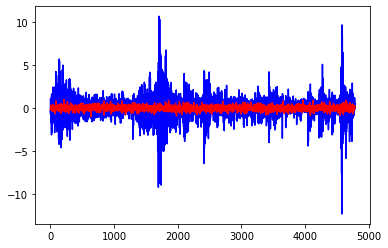

In [ ]:
params = Heston.calibrate()

In [ ]:
params=np.array([ 1.20106692e+00,  8.86737492e-02,  3.21321381e-01,  1.12821414e-03, -2.39050628e-01])
predicted_prices=[]


for i in range(0,3):
  if i==0:
    period='pre-crisis'
  if i==1:
    period='crisis'
  if i==2:
    period='post-crisis'
  if period == 'pre-crisis':
    data = option_data[(option_data['date'] >= pd.Timestamp(2003,1,1)) & (option_data['date'] < pd.Timestamp(2007,1,1))]
  elif period == 'crisis':
    data = option_data[(option_data['date'] >= pd.Timestamp(2007,1,1)) & (option_data['date'] < pd.Timestamp(2010,1,1))]
  elif period == 'post-crisis':
    data = option_data[(option_data['date'] >= pd.Timestamp(2010,1,1)) & (option_data['date'] < pd.Timestamp(2013,1,1))]
  else:
    raise ValueError('Not a valid string for period')

  print(period)
  prices=Heston.price_american_options(data,params)
  predicted_prices=np.hstack((predicted_prices,prices))

savetxt('heston_prediction.csv', predicted_prices, delimiter=',')
files.download("heston_prediction.csv")


pre-crisis
0
3504
7008
10512
14016
17520
21024
24528
28032
31536
MAPE: 0.7329983272246912
RMSE: 4.91708388202715
total time: 1461.707709550912, time per option: 0.04171659321187569
crisis
0
3670
7340
11010
14680
18350
22020
25690
29360
33030
MAPE: 0.6938676632478358
RMSE: 6.548476150446655
total time: 1443.8746176392833, time per option: 0.039344776762746836
post-crisis
0
3176
6352
9528
12704
15880
19056
22232
25408
28584
MAPE: 0.7390427384784961
RMSE: 6.041260037677221
total time: 1224.3494190569818, time per option: 0.03855125851119311


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ad-hoc Black-Scholes (AH-BS)

This contains the steps seperately for testing, the full object oriented, commented code is in Class ad-hoc black scholes


In [ ]:
max_vec=np.vectorize(max, otypes=[np.float64])

def create_regression_data(X):
  X_reg = X[['strike_price','maturity']]
  X_reg['KT']=(X_reg['strike_price']*X_reg['maturity'])
  X_reg=X_reg.values
  return X_reg

def implied_volatility(data):
  underlying = data[['underlying']].values.ravel().astype(float)
  strike_price = data[['strike_price']].values.ravel().astype(float)
  maturity = data[['maturity']].values.ravel().astype(float)
  interest_rate = data[['interest_rate']].values.ravel().astype(float)/250
  #interest_rate = interest_rate*0
  value = data[['market price']].values.ravel().astype(float)
  return find_vol(value,interest_rate,underlying,maturity,strike_price)

def calculate_prices(vol,data):
  underlying = data[['underlying']].values.ravel().astype(float)
  strike_price = data[['strike_price']].values.ravel().astype(float)
  maturity = data[['maturity']].values.ravel().astype(float)
  interest_rate = data[['interest_rate']].values.ravel().astype(float)/250
  #interest_rate = interest_rate*0
  #return bs_formula_P(interest_rate,vol,underlying,maturity,strike_price)
  return max_vec(bs_formula_P(interest_rate,vol,underlying,maturity,strike_price),0)

def find_vol(V,r,s,T,K):
    if isinstance(V, float):
        x0=np.ones(1)*0.5
    else:
        x0=np.ones(len(V))*0.5
    tol=10**-5
    f = lambda sigma: bs_formula_P(r,sigma,s,T,K)-V
    df = lambda sigma: vega(r,sigma,s,T,K)
    return newton(f,df,x0,tol)

def bs_formula_P(r,sigma,s,t,K):
    # Value of an European put option
    d1 = np.log(np.divide(s,K)) + np.divide(np.multiply((0.5*np.square(sigma)+r),t),np.multiply(sigma,np.sqrt(t)))
    d2 = d1 - np.multiply(sigma,np.sqrt(t))
    P = np.multiply(-s,norm.cdf(-d1)) + np.multiply(np.multiply(K,np.exp(np.multiply(-r,t))),norm.cdf(-d2))
    return P

def vega(r,sigma,s,t,K):
    d1 = np.log(np.divide(s,K)) + np.divide(np.multiply((0.5*np.square(sigma)+r),t),np.multiply(sigma,np.sqrt(t)))
    return np.multiply(np.multiply(s,norm.pdf(d1)),np.sqrt(t))

def newton(f,df,x0,tol):
    x = x0
    maxit = 100
    it = 0
    ind = np.abs(f(x)/df(x))>tol
    while it < maxit and np.any(ind):
        # Iterate on the indices that haven't yet converged
        ind = np.abs(f(x)/df(x))>tol
        x[ind]=x[ind]-np.divide(f(x),df(x))[ind]
        it=it+1
        # new set of indices to iterate on
    if np.any(ind):
        print('Warning: newton did not converge')
    else:
        print('converged in {it} iterations'.format(it = it))
    return x

#This array will have all prices obtained from the
predicted_prices_all=[]
predicted_prices_in_and_out=[]

for i in range(0,3):
  if i==0:
    period='pre-crisis'
  if i==1:
    period='crisis'
  if i==2:
    period='post-crisis'
  if period == 'pre-crisis':
    train = option_data[(option_data['date'] >= pd.Timestamp(2003,1,1)) & (option_data['date'] < pd.Timestamp(2006,7,1))]
    test = option_data[(option_data['date'] >= pd.Timestamp(2006,7,1)) & (option_data['date'] < pd.Timestamp(2007,1,1))]
  elif period == 'crisis':
    train = option_data[(option_data['date'] >= pd.Timestamp(2007,1,1)) & (option_data['date'] < pd.Timestamp(2009,7,1))]
    test = option_data[(option_data['date'] >= pd.Timestamp(2009,7,1)) & (option_data['date'] < pd.Timestamp(2010,1,1))]
  elif period == 'post-crisis':
    train = option_data[(option_data['date'] >= pd.Timestamp(2010,1,1)) & (option_data['date'] < pd.Timestamp(2012,7,1))]
    test = option_data[(option_data['date'] >= pd.Timestamp(2012,7,1)) & (option_data['date'] < pd.Timestamp(2013,1,1))]
  else:
    raise ValueError('Not a valid string for period')

  start_time=time.perf_counter()

  #Estimate the regression on train data
  impl_vol=implied_volatility(train)
  if i==0:
    training_data_pred=train
  else:
    training_data_pred=pd.concat((training_data_pred,train))
  X_reg = create_regression_data(train)
  y_true = train[['market price']].values.ravel()
  linreg = LinearRegression().fit(X_reg, impl_vol)

  #Add predicted prices to the vector of predicted prices (this can be ignored)
  vol_reg = linreg.predict(X_reg)
  y_reg = calculate_prices(vol_reg,train)
  if i==0:
    predicted_prices_in_and_out=np.hstack((predicted_prices_in_and_out,y_reg))
  else:
    predicted_prices_in_and_out=np.hstack((predicted_prices_in_and_out,np.zeros(len(training_data_pred)-len(predicted_prices_in_and_out))))
  training_data_pred=pd.concat((training_data_pred,test))

  #Predict test data using the estimated regression
  X_reg_pred = create_regression_data(test)
  vol_pred = linreg.predict(X_reg_pred)
  y_pred = calculate_prices(vol_pred,test)
  predicted_prices_in_and_out=np.hstack((predicted_prices_in_and_out,y_pred)) 
  y2 = test[['market price']].values.ravel()

  #Estimate on all data to get estimation errors
  if i==0:
    training_data=pd.concat((train,test))
  else:
    training_data=pd.concat((training_data,train,test))
  estimation_data=pd.concat((train,test))
  impl_vol=implied_volatility(training_data)
  X_reg_est = create_regression_data(training_data)
  linreg = LinearRegression().fit(X_reg_est, impl_vol)
  X_reg_est = create_regression_data(estimation_data)
  vol_est = linreg.predict(X_reg_est)
  y_est = calculate_prices(vol_est,estimation_data)
  y = estimation_data[['market price']].values.ravel()
  predicted_prices_all=np.hstack((predicted_prices_all,y_est))

  #Plot results
  #plt.figure(i)
  #plt.scatter(impl_vol,vol_est)
  #plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2)
  #plt.xlabel('impl vol')
  #plt.ylabel('reg vol')
  #plt.figure(i+3)
  #plt.scatter(y,calculate_prices(impl_vol,estimation_data),c='g')
  #plt.scatter(y,y_est,c='r')
  #plt.xlabel('true price')
  #plt.ylabel('model')

  end_time=time.perf_counter()

  #Calculate and print errors
  mape_in=np.mean(np.divide(np.abs(y_est-y),y))
  print(y[0:10])
  print(y_est[0:10])
  rmse_in=np.sqrt(np.mean((((y_est-y)**2))))
  mape_out=np.mean(np.divide(np.abs(y_pred-y2),y2))
  rmse_out=np.sqrt(np.mean((((y_pred-y2)**2))))

  print(period + " MAPE AH-BS in sample: " + str(mape_in))
  print(period + " RMSE AH-BS in sample: " + str(rmse_in))
  print(period + " MAPE AH-BS out sample: " + str(mape_out))
  print(period + " RMSE AH-BS out sample: " + str(rmse_out))
  print("time " + str(end_time-start_time))

savetxt('ahbs_estimation.csv', predicted_prices_all, delimiter=',')
files.download("ahbs_estimation.csv")
savetxt('ahbs_prediction.csv', predicted_prices_in_and_out, delimiter=',')
files.download("ahbs_prediction.csv")

converged in 7 iterations


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


converged in 7 iterations
[42.05   0.125  0.7    1.25   1.65   2.15   3.25   1.075  1.85   2.675]
[35.34393316  0.          0.          0.          0.          0.
  2.42338098  0.          0.          0.        ]
pre-crisis MAPE AH-BS in sample: 0.7646752590209573
pre-crisis RMSE AH-BS in sample: 4.248797278999317
pre-crisis MAPE AH-BS out sample: 0.7793734331615575
pre-crisis RMSE AH-BS out sample: 4.930745551292388
time 0.6870655530000249


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


converged in 9 iterations


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


converged in 9 iterations
[0.575 0.875 1.125 0.35  0.55  0.775 1.05  1.6   2.45  3.35 ]
[0.         0.         0.         0.         0.         0.
 1.77705596 3.69074974 5.62650919 7.58345773]
crisis MAPE AH-BS in sample: 0.7175807276501289
crisis RMSE AH-BS in sample: 8.796895523421066
crisis MAPE AH-BS out sample: 2.3268557415817144
crisis RMSE AH-BS out sample: 13.618105630059121
time 0.99386025900003


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


converged in 7 iterations


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


converged in 9 iterations
[ 1.6    2.175  3.2    4.95   7.35  10.5    1.125  7.4    8.75  10.4  ]
[ 8.39859627 10.5215203  12.67880771 14.87002018 17.09472381 19.35248907
  6.31047831 19.49916964 21.47014363 23.47214495]
post-crisis MAPE AH-BS in sample: 0.8140862169168339
post-crisis RMSE AH-BS in sample: 5.5349319335698715
post-crisis MAPE AH-BS out sample: 0.7961448688855137
post-crisis RMSE AH-BS out sample: 7.563748146964185
time 1.1906699439999784


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Class ad-hoc black scholes

In [ ]:
class AdHocBlackScholes():

  def __init__(self,
               training_data):
    impl_vol = self.implied_volatility(training_data)
    X_reg = self.create_regression_data(training_data)
    self.linreg = LinearRegression().fit(X_reg, impl_vol)
    self.max_vec = np.vectorize(max, otypes=[np.float64])     

  def create_regression_data(self,X):
    '''
    Picks up the correct data for regression
    '''
    X_reg = X[['strike_price','maturity']]
    X_reg['KT']=(X_reg['strike_price']*X_reg['maturity'])
    X_reg=X_reg.values
    return X_reg

  def implied_volatility(self,data):
    '''
    Process data to and passes it to implied volatility calculator
    '''
    underlying = data[['underlying']].values.ravel().astype(float)
    strike_price = data[['strike_price']].values.ravel().astype(float)
    maturity = data[['maturity']].values.ravel().astype(float)
    interest_rate = data[['interest_rate']].values.ravel().astype(float)/250
    #interest_rate = interest_rate*0
    value = data[['market price']].values.ravel().astype(float)
    return self.find_vol(value,interest_rate,underlying,maturity,strike_price)

  def calculate_prices(self,vol,data):
    '''
    Calculates option prices using the AH_BS algorithm
    '''
    underlying = data[['underlying']].values.ravel().astype(float)
    strike_price = data[['strike_price']].values.ravel().astype(float)
    maturity = data[['maturity']].values.ravel().astype(float)
    interest_rate = data[['interest_rate']].values.ravel().astype(float)/250
    return self.max_vec(self.bs_formula_P(interest_rate,vol,underlying,maturity,strike_price),0)

  def find_vol(self,V,r,s,T,K):
    '''
    Calculates implied vol, using newton's method
    '''
      if isinstance(V, float):
          x0=np.ones(1)*0.5
      else:
          x0=np.ones(len(V))*0.5
      tol=10**-5
      f = lambda sigma: self.bs_formula_P(r,sigma,s,T,K)-V
      df = lambda sigma: self.vega(r,sigma,s,T,K)
      return self.newton(f,df,x0,tol)

  def bs_formula_P(self,r,sigma,s,t,K):
    '''
    Black-Scholes formula for put option
    '''
      # Value of an European put option
      d1 = np.log(np.divide(s,K)) + np.divide(np.multiply((0.5*np.square(sigma)+r),t),np.multiply(sigma,np.sqrt(t)))
      d2 = d1 - np.multiply(sigma,np.sqrt(t))
      P = np.multiply(-s,norm.cdf(-d1)) + np.multiply(np.multiply(K,np.exp(np.multiply(-r,t))),norm.cdf(-d2))
      return P

  def vega(self,r,sigma,s,t,K):
    '''
    Black-Scholees vega
    '''
      d1 = np.log(np.divide(s,K)) + np.divide(np.multiply((0.5*np.square(sigma)+r),t),np.multiply(sigma,np.sqrt(t)))
      return np.multiply(np.multiply(s,norm.pdf(d1)),np.sqrt(t))

  def newton(self,f,df,x0,tol):
    '''
    Newtons method
    '''
      x = x0
      maxit = 100
      it = 0
      ind = np.abs(f(x)/df(x))>tol
      while it < maxit and np.any(ind):
          # Iterate on the indices that haven't yet converged
          ind = np.abs(f(x)/df(x))>tol
          x[ind]=x[ind]-np.divide(f(x),df(x))[ind]
          it=it+1
          # new set of indices to iterate on
      if np.any(ind):
          print('Warning: newton did not converge')
      else:
          print('converged in {it} iterations'.format(it = it))
      return x

  def price_AH_BS(self,data):
    '''
    Function that passes data to the correct functions to price
    '''
    X_reg = self.create_regression_data(data)
    vol_reg = self.linreg.predict(X_reg)
    y_reg = self.calculate_prices(vol_reg,data)
    return y_reg

In [ ]:
train = option_data[(option_data['date'] >= pd.Timestamp(2003,1,1)) & (option_data['date'] < pd.Timestamp(2006,7,1))]
test = option_data[(option_data['date'] >= pd.Timestamp(2006,7,1)) & (option_data['date'] < pd.Timestamp(2007,1,1))]
market_model=AdHocBlackScholes(train)
print(market_model.price_AH_BS(test)[0:10])

converged in 7 iterations
[0.         0.         0.         0.         0.         0.45343296
 2.23264765 4.03344775 5.85395994 7.69184908]
5.4712283265930195e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
